# Predicting Titanic Survivers
Like Titanic, this is my maiden voyage,  when it comes to Kaggle contest that is!. I've completed the Data Science track on Data Camp, but I'm a relative newbie when it comes to machine learning. I'm going to attempt to work my way through the Titanic: Machine Learning contest. My aim is to submission and initial entry as quickly as possible to get a base line score and then attempt to improve on  on it by first looking at missing data, then engineering key features before establishing a  secondary base line and trying to improve the model itself. I'd like to be able to achieve a score of .80

Please feel free to post comments or  make suggestions as to what i may be doing wrong or could maybe do better and  consider upvoting if you find the notebook useful!

Because this notebook has built up over time I have commented out some of the lines that output files so that when i want to output and test a slight change to the code, i don't output files for bit of the notebook that haven't been changed and that i am not especially intereted in. If you are forking this code you can simple remove the hash and output the file. I have also experimented with different models, so the current model in any stage is not necessarily the most efficent (its just the one that i tried last).

# Import the Libraries and Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.cross_validation import KFold

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

print(os.listdir("./"))

# Any results you write to the current directory are saved as output.

df_train=pd.read_csv('train.csv',sep=',')
df_test=pd.read_csv('test.csv',sep=',')
df_data = df_train.append(df_test) # The entire data: train + test.

PassengerId = df_test['PassengerId']
Submission=pd.DataFrame()
Submission['PassengerId'] = df_test['PassengerId']

['train.csv', 'gender_submission.csv', 'test.csv', 'Titanic practice by Davidcoxon.ipynb', '.ipynb_checkpoints']


/home/jun/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Stage 1 : Explore the Data and create a basic model on raw data

# Explore the data Statistically

### Number of rows and columns 

In [2]:
# How big are the training and test datasets
print(df_train.shape)
print("----------------------------")
print(df_test.shape)

(891, 12)
----------------------------
(418, 11)


### Column Names

In [3]:
# What are the column names 
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

### Data Types

In [4]:
# What type of data object are in each column and how many missing values are there
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB


### Missing Data

How much Data is missing from the training and test datasets, how important is that data and how much data cleaning might be required.

In [5]:
#check for any other unusable values
print(pd.isnull(df_data).sum())

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


## Observations on missing data.

There are 144 missing ages in the training data and 86 mssing ages in the test data. Age is an important feature so it is worth spending time to address this properly. 

There are 468 missing Cabin entries in the training data and 326 in the test data, at this stage I'm not sure how important this feature is so I'm going to revisit this when I know more about the feature.
There are 2 missing embarked data points in the train data and 1 missing fare in the test data, at this stage this does not represent a problem.

## Statistical Overview of the data

In [6]:
# Get a statistical overview of the training data
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# Get a statistical overview of the data
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Note: The mean and Std of each of the columns in the 2 datasets are reasonable close together, so its safe to assume that any relationships we discover in the  training data should work similarly in the test data.

In [8]:
# Take a look at some sample data
df_train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
df_train.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


# Explore Data Graphically

## Survival by Age, Class and Gender

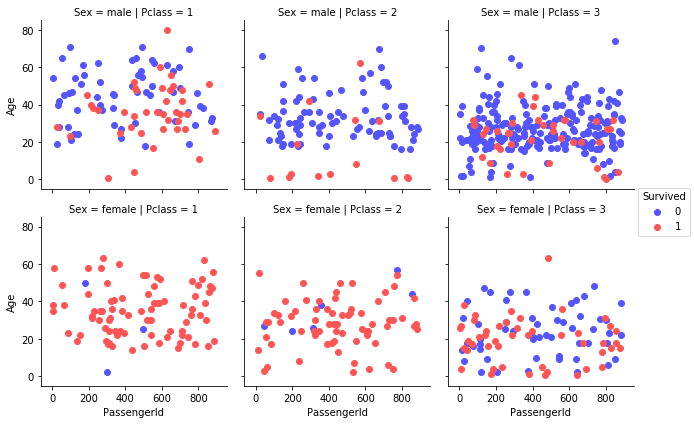

In [10]:
grid = sns.FacetGrid(df_train, col = "Pclass", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

## Survival by Age, Port of Embarkation and Gender

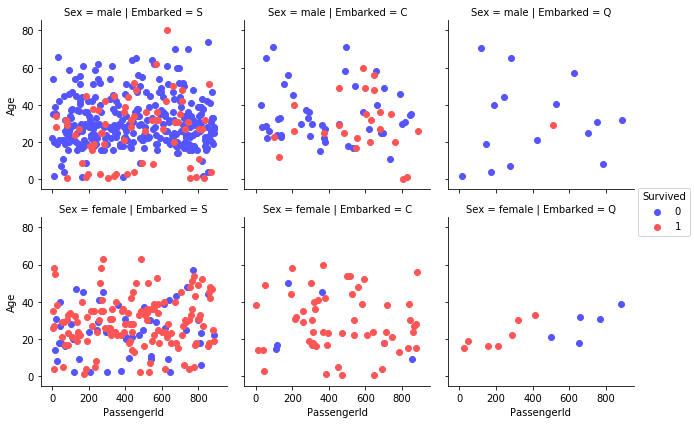

In [11]:
grid = sns.FacetGrid(df_train, col = "Embarked", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

This embarkation visualization indicates that a large proportion of passengers embarked at port 'S', with lesser numbers at 'C' and 'Q' it also shows that regardless of embarkation port more women survived than men. It doesn't seem to show any corelation between passenger ID and Embarkation port. Interestingly Embarkation port Q seems to indicate that  only 1 man survived while all women with passenger ID below 500 seem to survive while those above didn't this may be chance but it does look odd compared to 'S' and 'C'.

## Survival by Age, Number of Siblings and Gender

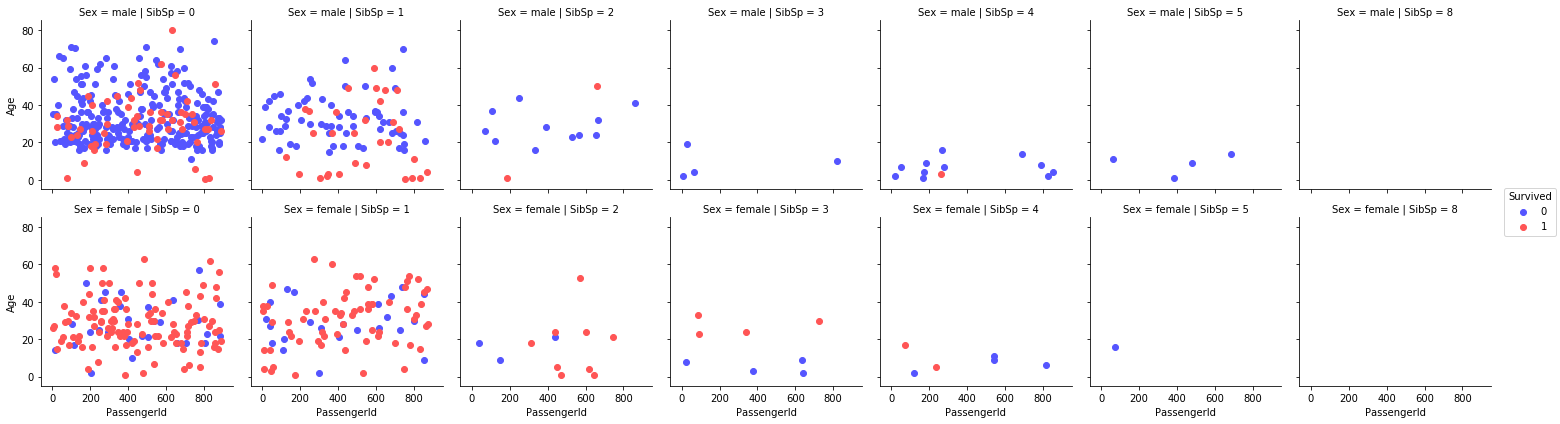

In [12]:
grid = sns.FacetGrid(df_train, col = "SibSp", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

## Survival by Age, Number of parch and Gender

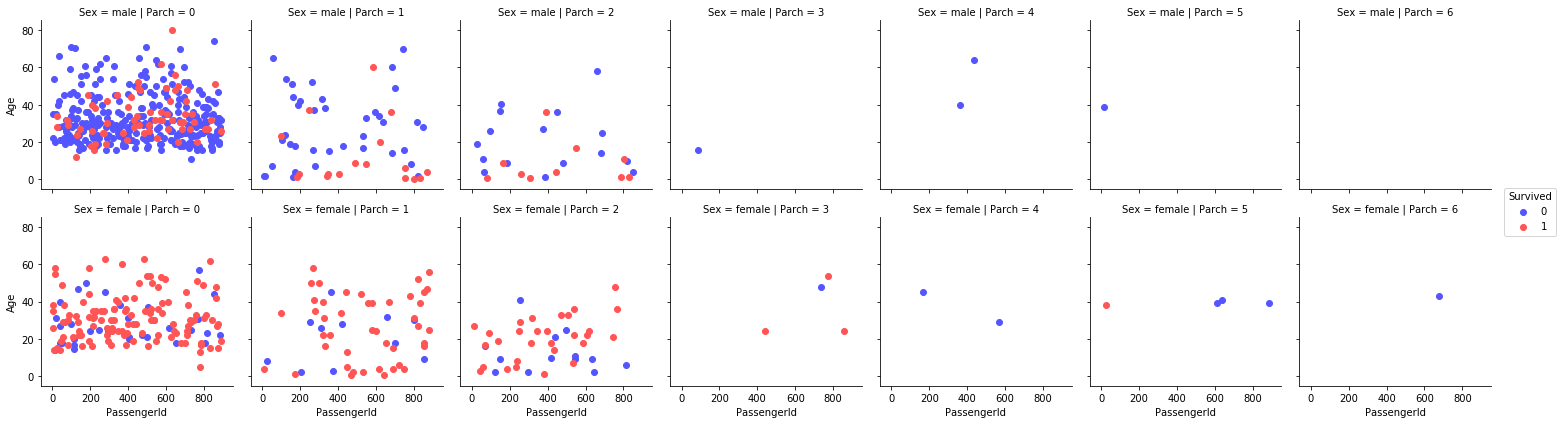

In [13]:
grid = sns.FacetGrid(df_train, col = "Parch", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

# Pairplots

To get a very basic idea of the relationships between the different features we can use pairplots from seaborn.

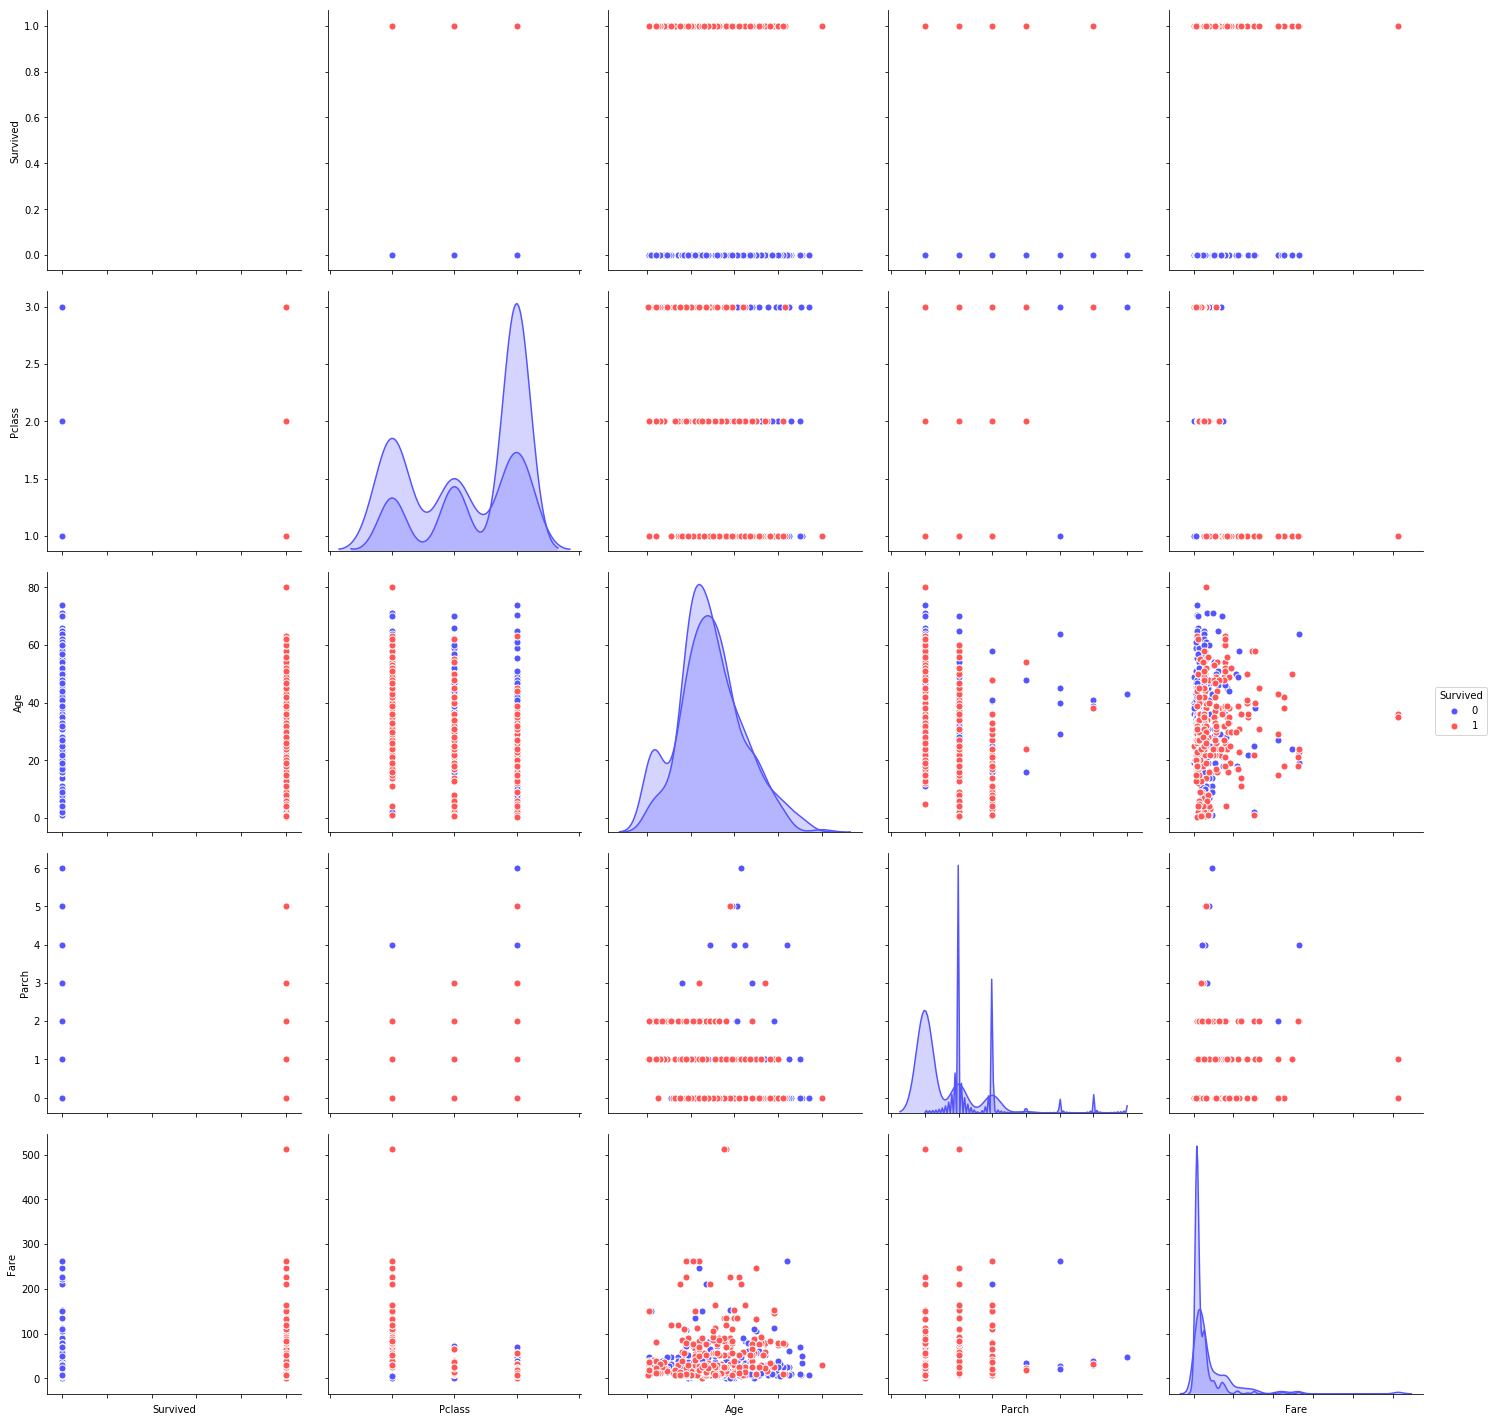

In [14]:
g = sns.pairplot(df_train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked']], hue='Survived', palette = 'seismic',size=4,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])

# Create simple model

Create a baseline score by using old the standard numeric data on on a very basic model, this will be used to see how much any changes we make to the data or model improve performance.

In [15]:
NUMERIC_COLUMNS=['Pclass','Age','SibSp','Parch','Fare']

# create test and training data
data_to_train = df_train[NUMERIC_COLUMNS].fillna(-1000)
y=df_train['Survived']
X=data_to_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=21, stratify=y)

from sklearn.svm import LinearSVC

clf = SVC()
clf.fit(X_train, y_train)
linear_svc = LinearSVC()

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 0.6791044776119403


# Create initial predictions¶

In [16]:
test = df_test[NUMERIC_COLUMNS].fillna(-1000)
Submission['Survived']=clf.predict(test)
print(Submission.head())
print('predictions generated')


   PassengerId  Survived
0          892         0
1          893         0
2          894         1
3          895         0
4          896         0
predictions generated


# Make first Submission

In [17]:
# write data frame to csv file
#Submission.set_index('PassengerId', inplace=True)
#Submission.to_csv('myfirstsubmission.csv',sep=',')
print('file created')

file created


The result of this first submission was a score of 0.57894. This constitutes performing just above random, if i'd simply flipped a coin fair coin for each passenger i could have achieved this kind of score. So there is plenty of room for improvement.

# Stage 2 : Clean Data & Engineer features to improve results

 

## Cleaning the data : Filling in the blanks
There are a number of missing values, including fare, embarked, age and cabin. I started off simply using the average value for fare, embarked and age. However after doing some visual data analysis it became obvious that I could use other factors like title to make better estimates on age by simply using the average for people with the same title, the same applied to embarked where average based on fare would give a better estimate and fare based on embarked. 

Cabin has so much missing data that it is likely that estimating cabin may add a level of noise to the data that would not be helpful.

## Feature Engineering
Here we are going to manipulate the existing data and try and create new features that our model can use. In some cases this is as simple as changing male and female to numeric data like 0 or 1. We can also separate categorical data to values between 1 and 5 for different titles, alternately we could put each categorical value into its own column, and mark columns with a 0 if they don't apply or a 1 if they do. So features may be quite complex so for example calculating cabin numbers based on surname, and ticket details. 

## Estimate missing Fare Data based on Embarkation
While there is relatively little missing Fare data, the range of possible values is large, so rather than using simply the media of all fares, we can look at the passenger class or embarkation port in order to use a more appropriate average. We'll start by looking at boxplots for the fares to ensure we are making soon assumptions before we go onto estimating the missing values.

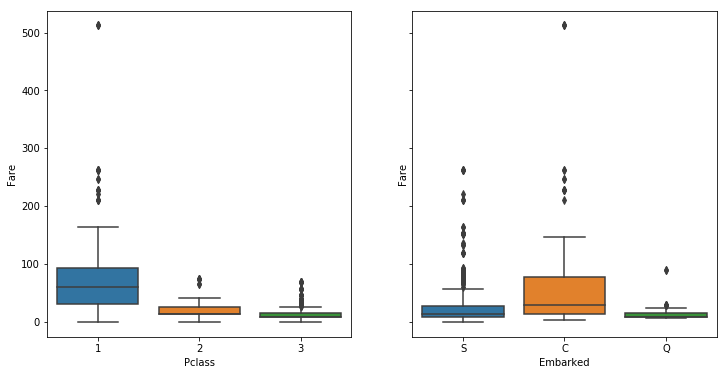

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(12,6))
sns.boxplot(data = df_train, x = "Pclass", y = "Fare",ax=ax1);
plt.figure(1)
sns.boxplot(data = df_train, x = "Embarked", y = "Fare",ax=ax2);
plt.show()

In [19]:
# Fill the na values in Fare based on embarked data
embarked = ['S', 'C', 'Q']
for port in embarked:
    fare_to_impute = df_data.groupby('Embarked')['Fare'].median()[embarked.index(port)]
    df_data.loc[(df_data['Fare'].isnull()) & (df_data['Embarked'] == port), 'Fare'] = fare_to_impute
# Fare in df_train and df_test:
df_train["Fare"] = df_data['Fare'][:891]
df_test["Fare"] = df_data['Fare'][891:]
print('Missing Fares Estimated')

Missing Fares Estimated


## FareBand feature

In [20]:
#fill in missing Fare value in training set based on mean fare for that Pclass 
for x in range(len(df_train["Fare"])):
    if pd.isnull(df_train["Fare"][x]):
        pclass = df_train["Pclass"][x] #Pclass = 3
        df_train["Fare"][x] = round(df_train[df_train["Pclass"] == pclass]["Fare"].mean(), 8)
        
#fill in missing Fare value in test set based on mean fare for that Pclass         
for x in range(len(df_test["Fare"])):
    if pd.isnull(df_test["Fare"][x]):
        pclass = df_test["Pclass"][x] #Pclass = 3
        df_test["Fare"][x] = round(df_test[df_test["Pclass"] == pclass]["Fare"].mean(), 8)
        
#map Fare values into groups of numerical values
df_data["FareBand"] = pd.qcut(df_data['Fare'], 8, labels = [1, 2, 3, 4,5,6,7,8]).astype('int')
df_train["FareBand"] = pd.qcut(df_train['Fare'], 8, labels = [1, 2, 3, 4,5,6,7,8]).astype('int')
df_test["FareBand"] = pd.qcut(df_test['Fare'], 8, labels = [1, 2, 3, 4,5,6,7,8]).astype('int')
df_train[["FareBand", "Survived"]].groupby(["FareBand"], as_index=False).mean()
print('FareBand feature created')

FareBand feature created


*** Note:*** There are several ways that machine learning can evaluate data, you can use discrete data like fare, or you can make that data categorical by grouping it into bands as i have done here or your can take those categories and turn each category into a column. Different models work, differently depending on how you give them the data. I'm going to create all 3 different structures for some features like fare and age and see how they compare. You shoud not over emphasis a feature by using multiple structures of the same data in a model, we'll therefore filter the differnet stuctures before we evaluate the models. 

## Embarked Feature

In [21]:
#map each Embarked value to a numerical value
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
df_data["Embarked"] = df_data["Embarked"].map(embarked_mapping)
# split Embanked into df_train and df_test:
df_train["Embarked"] = df_data["Embarked"][:891]
df_test["Embarked"] = df_data["Embarked"][891:]
print('Embarked feature created')
df_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

Embarked feature created


,Embarked,Survived
0,1.0,0.336957
1,2.0,0.553571
2,3.0,0.389610


## Estimate missing Embarkation Data

In [22]:
# Fill the na values in Embanked based on fareband data
fareband = [1,2,3,4]
for fare in fareband:
    embark_to_impute = df_data.groupby('FareBand')['Embarked'].median()[fare]
    df_data.loc[(df_data['Embarked'].isnull()) & (df_data['FareBand'] == fare), 'Embarked'] = embark_to_impute
# Fare in df_train and df_test:
df_train["Embarked"] = df_data['Embarked'][:891]
df_test["Embarked"] = df_data['Embarked'][891:]
print('Missing Embarkation Estimated')

Missing Embarkation Estimated


We will come back to fill in the missing age data a little later. Initially i created an estimate based on the mean age and standard deviation, using random numbers to evenly distribute age estimates, which worked, but actually there is a better way using title. As we have not yet extracted the title data yet, we will wait to estimate ages until we have. 

##  Gender Feature

In [23]:
# convert categories to Columns
dummies=pd.get_dummies(df_train[['Sex']], prefix_sep='_') #Gender
df_train = pd.concat([df_train, dummies], axis=1) 
testdummies=pd.get_dummies(df_test[['Sex']], prefix_sep='_') #Gender
df_test = pd.concat([df_test, testdummies], axis=1) 
print('Gender Feature added ')

Gender Feature added 


In [24]:
#map each Gendre value to a numerical value
gender_mapping = {"female": 0, "male": 1}
df_data["Sex"] = df_data['Sex'].map(gender_mapping)
df_data["Sex"]=df_data["Sex"].astype('int')

# Family_Survival in TRAIN_DF and TEST_DF:
df_train["Sex"] = df_data["Sex"][:891]
df_test["Sex"] = df_data["Sex"][891:]
print('Gender Category created')

Gender Category created


## Title Feature

In [25]:
#Get titles
df_data["Title"] = df_data.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

#Unify common titles. 
df_data["Title"] = df_data["Title"].replace('Mlle', 'Miss')
df_data["Title"] = df_data["Title"].replace('Master', 'Master')
df_data["Title"] = df_data["Title"].replace(['Mme', 'Dona', 'Ms'], 'Mrs')
df_data["Title"] = df_data["Title"].replace(['Jonkheer','Don'],'Mr')
df_data["Title"] = df_data["Title"].replace(['Capt','Major', 'Col','Rev','Dr'], 'Millitary')
df_data["Title"] = df_data["Title"].replace(['Lady', 'Countess','Sir'], 'Honor')

# Age in df_train and df_test:
df_train["Title"] = df_data['Title'][:891]
df_test["Title"] = df_data['Title'][891:]

# convert Title categories to Columns
titledummies=pd.get_dummies(df_train[['Title']], prefix_sep='_') #Title
df_train = pd.concat([df_train, titledummies], axis=1) 
ttitledummies=pd.get_dummies(df_test[['Title']], prefix_sep='_') #Title
df_test = pd.concat([df_test, ttitledummies], axis=1) 
print('Title categories added')

Title categories added


## Title Cetegory

In [26]:
# Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Millitary": 5, "Honor": 6}
df_data["TitleCat"] = df_data['Title'].map(title_mapping)
df_data["TitleCat"] = df_data["TitleCat"].astype(int)
df_train["TitleCat"] = df_data["TitleCat"][:891]
df_test["TitleCat"] = df_data["TitleCat"][891:]
print('Title Category created')

Title Category created


## Fill age based on title

The Visualisations of age by title suggests that if  we  create our age estimate by looking at the passengers title and using the average age for that title it may produce a more accurate estimate.  

In [27]:
titles = ['Master', 'Miss', 'Mr', 'Mrs', 'Millitary','Honor']
for title in titles:
    age_to_impute = df_data.groupby('Title')['Age'].median()[title]
    df_data.loc[(df_data['Age'].isnull()) & (df_data['Title'] == title), 'Age'] = age_to_impute
# Age in df_train and df_test:
df_train["Age"] = df_data['Age'][:891]
df_test["Age"] = df_data['Age'][891:]
print('Missing Ages Estimated')

Missing Ages Estimated


## Create Agebands

In [28]:
#map Fare values into groups of numerical values
df_data["AgeBand"] = pd.qcut(df_data['Age'], 8, labels = [1, 2, 3, 4,5,6,7,8]).astype('int')
df_train["AgeBand"] = pd.qcut(df_train['Age'], 8, labels = [1, 2, 3, 4,5,6,7,8]).astype('int')
df_test["AgeBand"] = pd.qcut(df_test['Age'], 8, labels = [1, 2, 3, 4,5,6,7,8]).astype('int')
df_train[["AgeBand", "Survived"]].groupby(["AgeBand"], as_index=False).mean()
print('AgeBand feature created')

AgeBand feature created


## Visualize Age Data

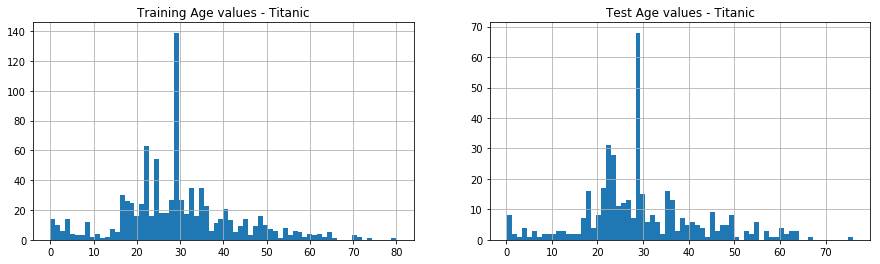

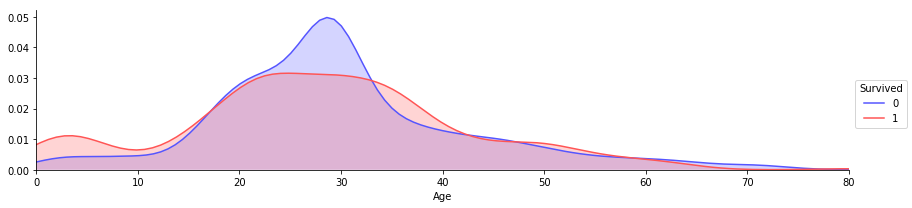

In [29]:
# Visualise Age Data 
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(15,4))
axis1.set_title('Training Age values - Titanic')
axis2.set_title('Test Age values - Titanic')

# plot original Age values
df_train['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
#df_test['Age'].dropna().astype(int).hist(bins=70, ax=axis1)
        
# plot new Age Values
#df_train['Age'].hist(bins=70, ax=axis2)
df_test['Age'].hist(bins=70, ax=axis2)

# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(df_train, hue="Survived",palette = 'seismic',aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_train['Age'].max()))
facet.add_legend()

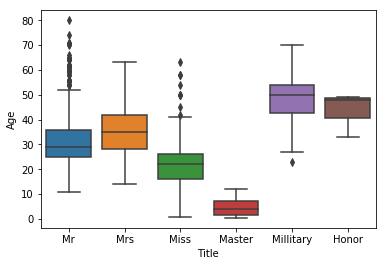

In [30]:
sns.boxplot(data = df_train, x = "Title", y = "Age");

## Lone Travellers Feature 

In [31]:
df_train["Alone"] = np.where(df_train['SibSp'] + df_train['Parch'] + 1 == 1, 1,0) # People travelling alone
df_test["Alone"] = np.where(df_test['SibSp'] + df_test['Parch'] + 1 == 1, 1,0) # People travelling alone
print('Lone traveller feature created')

Lone traveller feature created


## Family Size Feature

In [32]:
df_train["Family Size"] = (df_train['SibSp'] + df_train['Parch'] + 1)
df_test["Family Size"] = df_test['SibSp'] + df_test['Parch'] + 1
print('Family size feature created')

Family size feature created


## Family Survival

This is based on code taken from from https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever

In [33]:
# get last name
df_data["Last_Name"] = df_data['Name'].apply(lambda x: str.split(x, ",")[0])
# Set survival value
DEFAULT_SURVIVAL_VALUE = 0.5
df_data["Family_Survival"] = DEFAULT_SURVIVAL_VALUE

# Find Family groups by Fare
for grp, grp_df in df_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Family_Survival'] = 0

print("Number of passengers with family survival information:", 
      df_data.loc[df_data['Family_Survival']!=0.5].shape[0])

# Find Family groups by Ticket
for _, grp_df in df_data.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    df_data.loc[df_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    df_data.loc[df_data['PassengerId'] == passID, 'Family_Survival'] = 0
                        
print("Number of passenger with family/group survival information: " 
      +str(df_data[df_data['Family_Survival']!=0.5].shape[0]))

# Family_Survival in df_train and df_test:
df_train["Family_Survival"] = df_data['Family_Survival'][:891]
df_test["Family_Survival"] = df_data['Family_Survival'][891:]

Number of passengers with family survival information: 420
Number of passenger with family/group survival information: 546


## Cabin feature

In [34]:
# check if cabin inf exists
df_data["HadCabin"] = (df_data["Cabin"].notnull().astype('int'))
# split Embanked into df_train and df_test:
df_train["HadCabin"] = df_data["HadCabin"][:891]
df_test["HadCabin"] = df_data["HadCabin"][891:]
print('Cabin feature created')

Cabin feature created


## Deck feature

In [35]:
# Extract Deck
df_data["Deck"] = df_data.Cabin.str.extract('([A-Za-z])', expand=False)
df_data["Deck"] = df_data["Deck"].fillna("N")
# Map Deck
deck_mapping = {"N":0,"A": 1, "B": 2, "C": 3, "D": 4, "E": 5}
df_data['Deck'] = df_data['Deck'].map(deck_mapping)
#Split to training and test
df_train["Deck"] = df_data["Deck"][:891]
df_test["Deck"] = df_data["Deck"][891:]
print('Deck feature created')

Deck feature created


# Exploring the Engineered data

## Missing Data

In [36]:
#check for any other unusable values
print(pd.isnull(df_test).sum())

PassengerId          0
Pclass               0
Name                 0
Sex                  0
Age                  0
SibSp                0
Parch                0
Ticket               0
Fare                 0
Cabin              327
Embarked             0
FareBand             0
Sex_female           0
Sex_male             0
Title                0
Title_Master         0
Title_Millitary      0
Title_Miss           0
Title_Mr             0
Title_Mrs            0
TitleCat             0
AgeBand              0
Alone                0
Family Size          0
Family_Survival      0
HadCabin             0
Deck                 9
dtype: int64


## Statistical Overview

In [37]:
df_train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FareBand,...,Title_Miss,Title_Mr,Title_Mrs,TitleCat,AgeBand,Alone,Family Size,Family_Survival,HadCabin,Deck
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,889.000000,891.000000,...,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,873.000000
mean,446.000000,0.383838,2.308642,0.647587,29.302660,0.523008,0.381594,32.204208,1.362205,4.465769,...,0.206510,0.582492,0.142536,1.723906,4.296296,0.602694,1.904602,0.519641,0.228956,0.662085
std,257.353842,0.486592,0.836071,0.477990,13.240228,1.102743,0.806057,49.693429,0.636157,2.334332,...,0.405028,0.493425,0.349796,1.032114,2.321317,0.489615,1.613459,0.323961,0.420397,1.387739
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,2.500000,...,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,1.000000,0.500000,0.000000,0.000000
50%,446.000000,0.000000,3.000000,1.000000,29.000000,0.000000,0.000000,14.454200,1.000000,4.000000,...,0.000000,1.000000,0.000000,1.000000,4.000000,1.000000,1.000000,0.500000,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,6.000000,...,0.000000,1.000000,0.000000,2.000000,6.000000,1.000000,2.000000,0.500000,0.000000,0.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,3.000000,8.000000,...,1.000000,1.000000,1.000000,6.000000,8.000000,1.000000,11.000000,1.000000,1.000000,5.000000


# Visualizing age data
We could estimate all of the ages based on the mean and standard deviation of the data set, however as age is obviously an important feature in pridicting survival and we need to look at the other features and see if we can work out a way to make a more accurate estimate of age for any given passenger. First lets look at the different age distributions of passengers by title.

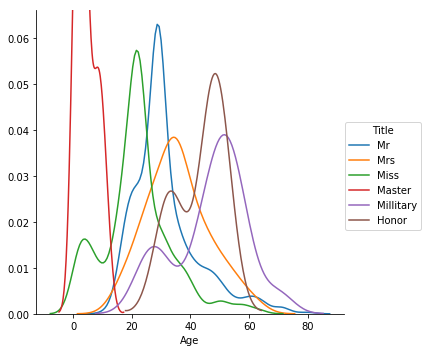

In [38]:
# Groupby title
df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
# plot age distribution by title
facet = sns.FacetGrid(data = df_train, hue = "Title", legend_out=True, size = 5)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

The age distribution looks slightly suspect and possibly merits further investigation, for example while master generally refers to male's under 16 there a number that are over 40, this might be explained if master is also a title in nautical terms like 'Master Seaman'. You might also expect a quite Normal distribution of ages for any given title, but in many cases this doesn't seem to be the case, this is most likely caused by out estimated numbers skewing the data, one way to avoid this would be to use a random number based on the standard deviation in the estimate for each to get a more natural dataset. We could also use age bands rather than age in the model.

### Survival by FareBand and Gender 

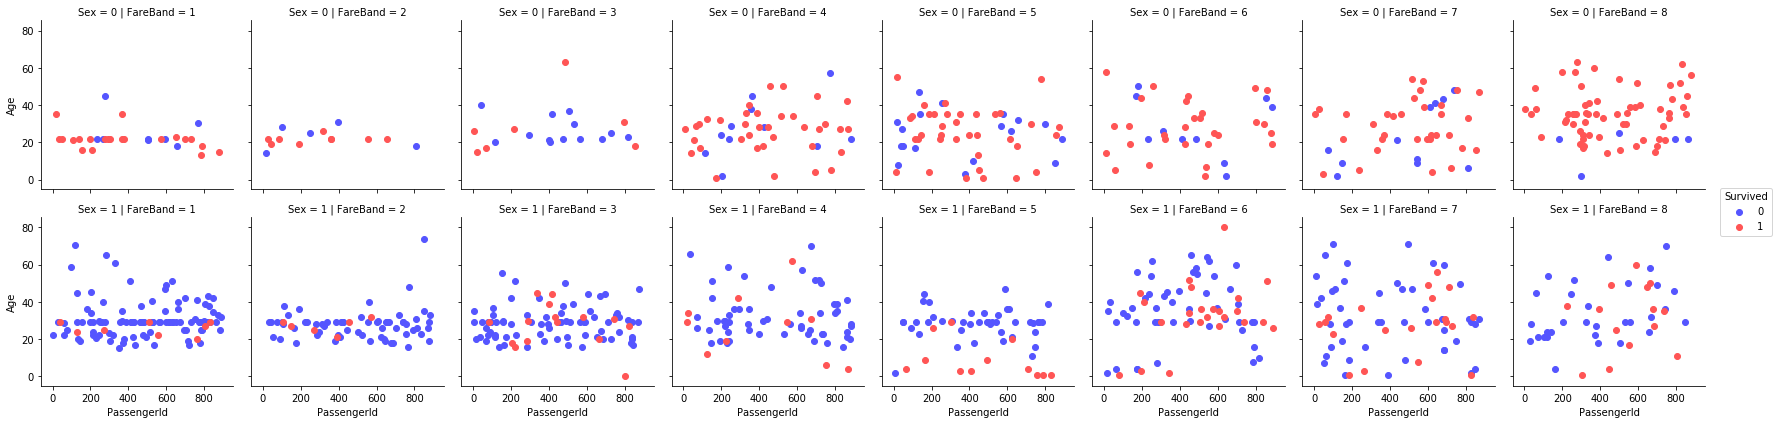

In [39]:
grid = sns.FacetGrid(df_train, col = "FareBand", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

### Survival by Deck and Gender 

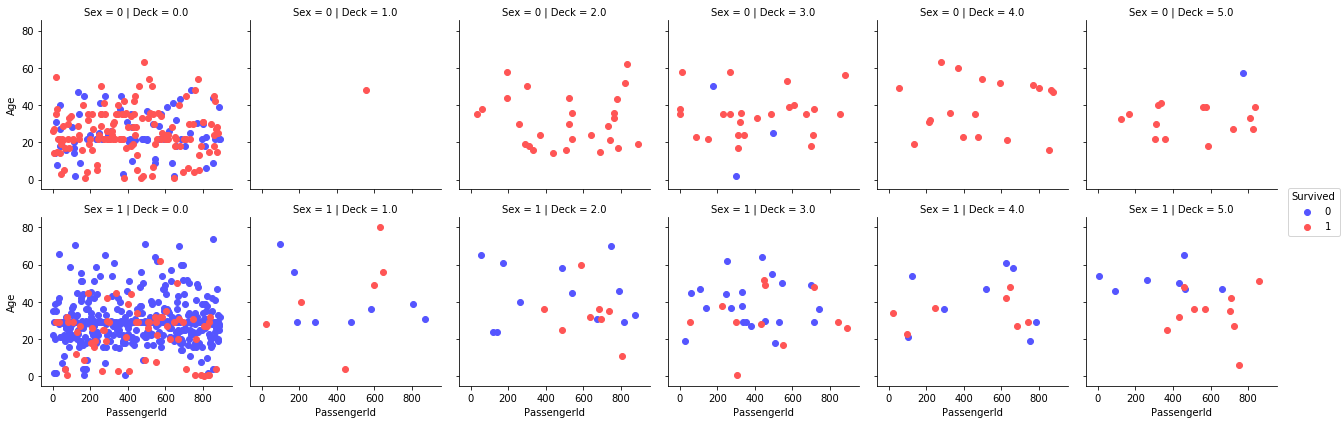

In [40]:
grid = sns.FacetGrid(df_train, col = "Deck", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

### Survival by Family Size and Gender 

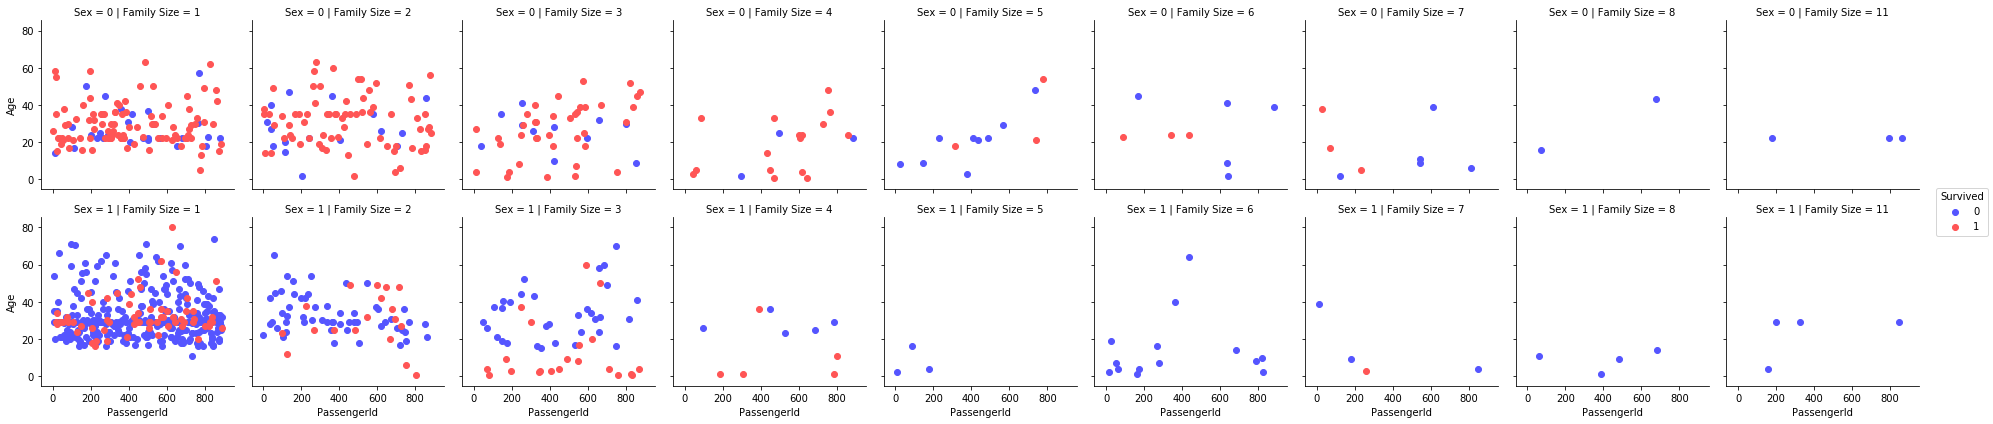

In [41]:
grid = sns.FacetGrid(df_train, col = "Family Size", row = "Sex", hue = "Survived", palette = 'seismic')
grid = grid.map(plt.scatter, "PassengerId", "Age")
grid.add_legend()
grid

### Survival by Passenger Class and Family Size

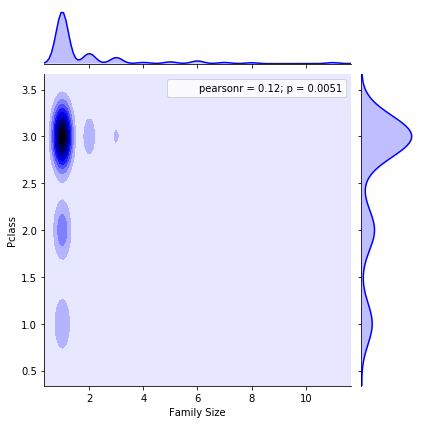

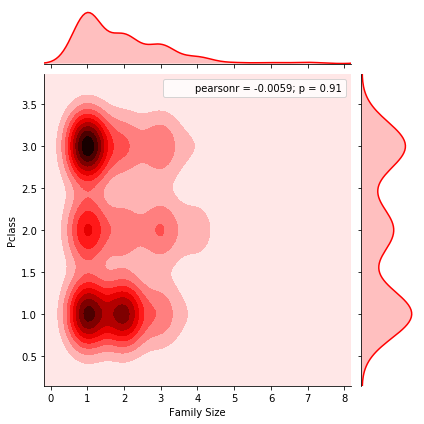

In [42]:
x1=df_train[df_train["Survived"]==0]
x2=df_train[df_train["Survived"]==1]

# Set up the matplotlib figure
plt.figure(1)
sns.jointplot(x="Family Size", y="Pclass", data=x1, kind="kde", color='b');
plt.figure(2)
sns.jointplot(x="Family Size", y="Pclass", data=x2, kind="kde", color='r');
plt.show()

### Fare Jointplot 

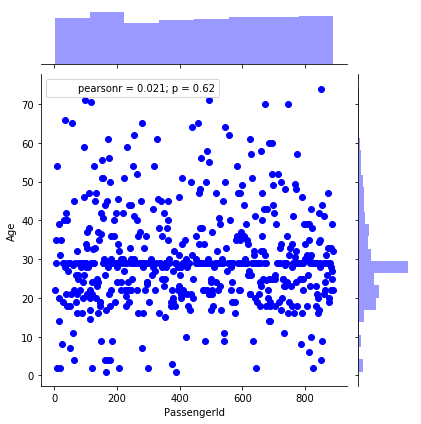

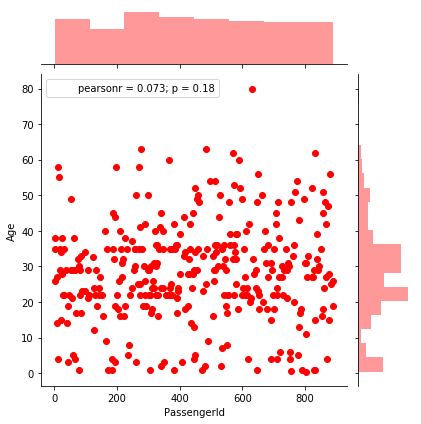

In [43]:
plt.figure(3)
sns.jointplot(data=x1, x='PassengerId', y='Age', kind='scatter',color='b')
plt.figure(4)
sns.jointplot(data=x2, x='PassengerId', y='Age', kind='scatter',color='r')

# sns.plt.show()

# Re-train the model on new features

In [44]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Title_Miss,Title_Mr,Title_Mrs,TitleCat,AgeBand,Alone,Family Size,Family_Survival,HadCabin,Deck
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,...,0,1,0,1,2,0,2,0.5,0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,...,0,0,1,3,7,0,2,0.5,1,3.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,0,2,4,1,1,0.5,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,...,0,0,1,3,6,0,2,0.0,1,3.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,...,0,1,0,1,6,1,1,0.5,0,0.0


# Re-evaluate the on new features

In [45]:
# Re-evaluate with new features

NUMERIC_COLUMNS=['Alone','Family Size','Sex','Pclass','Fare','FareBand','Age','TitleCat','Embarked'] #72
REVISED_NUMERIC_COLUMNS=['Pclass','Age','SibSp','Parch','Family_Survival','Alone','Sex_female','Sex_male','Title_Master', 'Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Millitary','Embarked'] #84

# create test and training data
data_to_train = df_train[REVISED_NUMERIC_COLUMNS].fillna(-1000)
X_train, X_test, y_train, y_test = train_test_split(data_to_train, df_train['Survived'], test_size=0.3,random_state=21, stratify=df_train['Survived'])

RandomForest = RandomForestClassifier(random_state = 0)
RandomForest.fit(X_train, y_train)
print('Evaluation complete')

Evaluation complete


In [46]:
# Print the accuracy# Print  
print("Accuracy: {}".format(RandomForest.score(X_test, y_test)))

Accuracy: 0.8134328358208955


## Feature Importance

In [47]:
RandomForest_checker = RandomForestClassifier()
RandomForest_checker.fit(X_train, y_train)
importances_df = pd.DataFrame(RandomForest_checker.feature_importances_, columns=['Feature_Importance'],
                              index=X_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
print(importances_df)

                 Feature_Importance
Age                        0.272566
Sex_male                   0.138579
Family_Survival            0.131662
Sex_female                 0.114225
Pclass                     0.111639
Title_Mr                   0.052402
SibSp                      0.046596
Parch                      0.038846
Embarked                   0.033019
Title_Miss                 0.031859
Title_Master               0.012317
Alone                      0.009637
Title_Mrs                  0.004275
Title_Millitary            0.002377


## Feature Correlation

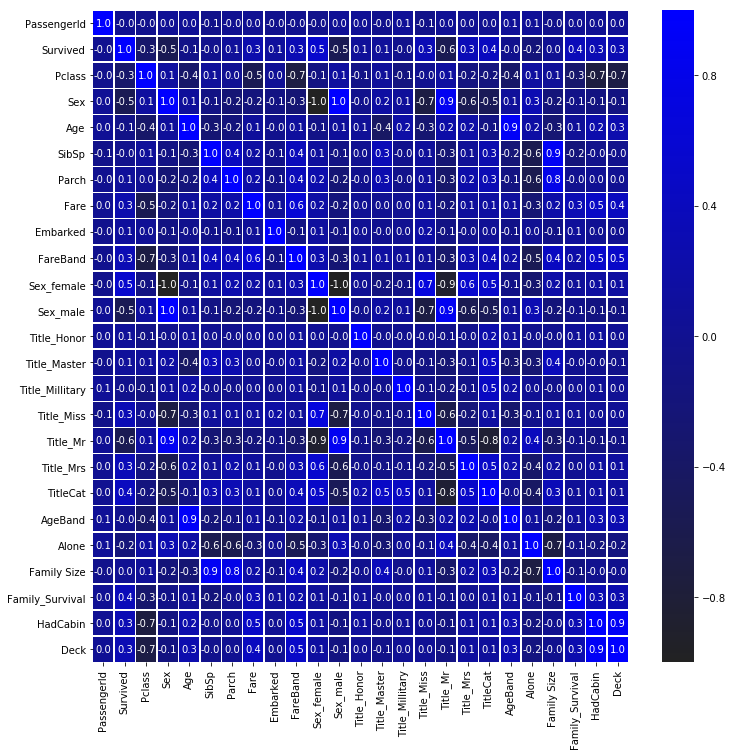

In [48]:
#map feature correlation
f,ax = plt.subplots(figsize=(12, 12))
pal = sns.dark_palette("blue", as_cmap=True)
sns.heatmap(df_train.corr(),annot=True,cmap=pal, linewidths=.5, fmt= '.1f',ax=ax)

# Re-forcast predictions based on new features

In [49]:
test = df_test[REVISED_NUMERIC_COLUMNS].fillna(-1000)
Submission['Survived']=RandomForest.predict(test)
print(Submission.head())
print('Submission created')

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
Submission created


# Make revised submission

In [50]:
# write data frame to csv file
# Submission.set_index('PassengerId', inplace=True)
#Submission.to_csv('finalrevised01.csv',sep=',')
print('file created')

file created


The second revised submission scored 0.75598 which was an improvement of the original revision which scored 0.64593, this used was  is an improvement on the original score of 0.57894. This advanced the submission to 9117 place on the leaderboard, from the starting point of 10599th place! Obviousy a step in the right direction but still needing work.

# Stage 3 : Test Different Models and parameters

## Split data into test and training

In [51]:
from sklearn.model_selection import train_test_split
NUMERIC_COLUMNS=['Alone','Family Size','Sex','Pclass','Fare','Age','TitleCat','FareBand','Embarked']
REVISED_NUMERIC_COLUMNS=['Pclass','Age','SibSp','Parch','Family_Survival','Alone','Sex_female','Sex_male','Title_Master', 'Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Millitary','Embarked'] #84

# create test and training data
data_to_train = df_train[REVISED_NUMERIC_COLUMNS].fillna(-1000)
prediction = df_train["Survived"]
X_train, X_val, y_train, y_val = train_test_split(data_to_train, prediction, test_size = 0.3,random_state=21, stratify=y)
print('Data split')

Data split


## Support Vector Machines

Has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.
1. This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

In [52]:
clf = SVC()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
acc_clf = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_clf)

83.96


## LinearSVC

In [53]:
# Linear SVC
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_val)
acc_linear_svc = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_linear_svc)

84.7


## Logistic Regression

In [54]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_val)
acc_logreg = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg)

84.7


## K Nearest Neighbors

In [55]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

81.72


## Gaussian Naive Bayes

In [56]:
# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_val)
acc_gaussian = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gaussian)

82.84


## Decision Tree

In [57]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
y_pred = decisiontree.predict(X_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

80.97


## Random Forest

In [58]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier(random_state = 0)
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

81.34


## Gradient Boosting 

In [59]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)
y_pred = gbk.predict(X_val)
acc_gbk = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk)

83.96


## Extra Trees

In [60]:
ExtraTreesClassifier
# Gradient Boosting Classifier
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier()
et.fit(X_train, y_train)
y_pred = et.predict(X_val)
acc_et = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_et)

82.46


## Stochastic Gradient Descent

In [61]:
# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_val)
acc_sgd = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_sgd)

69.78


### Perceptron

In [62]:
# Perceptron
from sklearn.linear_model import Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_val)
acc_perceptron = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_perceptron)

65.67


## xgboost

In [65]:
# xgboost
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=10)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_val)
acc_xgb = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_xgb)

85.82


## Comparing the results

In [66]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Classifier','Extra Trees','Stochastic Gradient Descent','Perceptron','xgboost'],
    'Score': [acc_clf, acc_knn, acc_logreg, 
              acc_randomforest, acc_gaussian,acc_linear_svc, acc_decisiontree,
             acc_gbk,acc_et,acc_sgd,acc_perceptron,acc_xgb]})
models.sort_values(by='Score', ascending=False)

,Model,Score
11,xgboost,85.82
2,Logistic Regression,84.70
5,Linear SVC,84.70
0,Support Vector Machines,83.96
7,Gradient Boosting Classifier,83.96
4,Naive Bayes,82.84
8,Extra Trees,82.46
1,KNN,81.72
3,Random Forest,81.34
6,Decision Tree,80.97


# Reforcast predictions based on best performing model

In [67]:
test = df_test[REVISED_NUMERIC_COLUMNS].fillna(-1000)

Submission['Survived']=xgb.predict(test)
print(Submission.head(5))
print('Prediction complete')

   PassengerId  Survived
0          892         0
1          893         1
2          894         0
3          895         0
4          896         1
Prediction complete


# Make model submission

In [68]:
# write data frame to csv file
#Submission.set_index('PassengerId', inplace=True)
#Submission.to_csv('finalsubmission.csv',sep=',')
#Submission.to_csv('xgbbasicsubmission01.csv',sep=',')
print('File created')

File created


# Stage 4 : Hyper Tuning the Models

In [69]:
from sklearn.model_selection import train_test_split
NUMERIC_COLUMNS=['Pclass','Age','SibSp','Parch','Sex_female','Sex_male','Title_Master', 'Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Services','FareBand','Embarked','Alone','Family Size']
REVISED_NUMERIC_COLUMNS=['Pclass','AgeBand','SibSp','Parch','Family_Survival','Family Size','Alone','Sex_female','Sex_male','Title_Master', 'Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Millitary','Embarked'] #84

# create test and training data
data_to_train = df_train[REVISED_NUMERIC_COLUMNS].fillna(-1000)
prediction = df_train["Survived"]
X_train, X_val, y_train, y_val = train_test_split(data_to_train, prediction, test_size = 0.3,random_state=21, stratify=prediction)
print('Data Split')

Data Split


## Linear Regression SVC

In [70]:
from sklearn.model_selection import GridSearchCV

# Support Vector Classifier parameters 
param_grid = {'C':np.arange(1, 7),
              'degree':np.arange(1, 7),
              'max_iter':np.arange(0, 12),
              'kernel':['rbf','linear'],
              'shrinking':[0,1]}

clf = SVC()
svc_cv=GridSearchCV(clf, param_grid, cv=10)
svc_cv.fit(X_train, y_train)

print("Tuned SVC Parameters: {}".format(svc_cv.best_params_))
print("Best score is {}".format(svc_cv.best_score_))
acc_svc_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_svc_cv)

Tuned SVC Parameters: {'C': 3, 'degree': 1, 'kernel': 'rbf', 'max_iter': 6, 'shrinking': 0}
Best score is 0.6581059390048154
85.82


## Logistic Regression

In [71]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# create parameter grid as a dictionary where the keys are the hyperparameter names and the values are lists of values that we want to try.
param_grid = {"solver": ['newton-cg','lbfgs','liblinear','sag','saga'],'C': [0.01, 0.1, 1, 10, 100]}

# instanciate classifier
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

logreg_cv = GridSearchCV(logreg, param_grid, cv=30)
logreg_cv.fit(X_train, y_train)

y_pred = logreg_cv.predict(X_val)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_))
print("Best score is {}".format(logreg_cv.best_score_))
acc_logreg_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_logreg_cv)

Tuned Logistic Regression Parameters: {'C': 10, 'solver': 'newton-cg'}
Best score is 0.8475120385232745
84.7


## KNN 

In [73]:
# KNN or k-Nearest Neighbors with GridSearch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# create parameter grid as a dictionary where the keys are the hyperparameter names and the values are lists of values that we want to try.
param_grid = {"n_neighbors": np.arange(1, 50),
             "leaf_size": np.arange(20, 40),
             "algorithm": ["ball_tree","kd_tree","brute"]
             }
# instanciate classifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_cv = GridSearchCV(knn, param_grid, cv=10)
knn_cv.fit(X_train, y_train)
y_pred = knn_cv.predict(X_val)
print("Tuned knn Parameters: {}".format(knn_cv.best_params_))
print("Best score is {}".format(knn_cv.best_score_))
acc_knn_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn_cv)

Tuned knn Parameters: {'algorithm': 'ball_tree', 'leaf_size': 20, 'n_neighbors': 10}
Best score is 0.8282504012841091
82.46


## DecisionTree with RandomizedSearch

In [74]:
# DecisionTree with RandomizedSearch

# Import necessary modules
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"random_state" :  np.arange(0, 10),
              "max_depth": np.arange(1, 10),
              "max_features": np.arange(1, 10),
              "min_samples_leaf": np.arange(1, 10),
              "criterion": ["gini","entropy"]}

# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=30)

# Fit it to the data
tree_cv.fit(X_train,y_train)
y_pred = tree_cv.predict(X_val)
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))
acc_tree_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_tree_cv)

Tuned Decision Tree Parameters: {'random_state': 8, 'min_samples_leaf': 6, 'max_features': 7, 'max_depth': 4, 'criterion': 'gini'}
Best score is 0.8362760834670947
82.46


## Random Forrest

In [77]:
# Random Forrest

# Import necessary modules
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {"random_state" :  np.arange(0, 10),
              "n_estimators" :  np.arange(1, 20),
              "max_depth": np.arange(1, 10),
              "max_features": np.arange(1, 10),
              "min_samples_leaf": np.arange(1, 10),
              "criterion": ["gini","entropy"]}

# Instantiate a Decision Tree classifier: tree
randomforest = RandomForestClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
randomforest_cv = RandomizedSearchCV(randomforest, param_dist, cv=30)

# Fit it to the data
randomforest_cv.fit(X_train,y_train)
y_pred = randomforest_cv.predict(X_val)
# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(randomforest_cv.best_params_))
print("Best score is {}".format(randomforest_cv.best_score_))
acc_randomforest_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest_cv)

## Gradient Boosting

In [78]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.cross_validation import KFold;

# Setup the parameters and distributions to sample from: param_dist
param_dist = {'max_depth':np.arange(1, 7),
              'min_samples_leaf': np.arange(1, 6),
              "max_features": np.arange(1, 10),
             }

# Instantiate Classifier
gbk = GradientBoostingClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
gbk_cv = RandomizedSearchCV(gbk, param_dist, cv=30)

gbk_cv.fit(X_train, y_train)
y_pred = gbk_cv.predict(X_val)

print("Tuned Gradient Boost Parameters: {}".format(gbk_cv.best_params_))
print("Best score is {}".format(gbk_cv.best_score_))
acc_gbk_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_gbk_cv)

## xgboost

In [79]:
# xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Setup the parameters and distributions to sample from: param_dist
param_dist = {'learning_rate': [.01, .03, .05, .1, .25], #default: .3
            'max_depth': np.arange(1, 10), #default 2
            'n_estimators': [10, 50, 100, 300], 
            'booster':['gbtree','gblinear','dart']
            #'seed': 5  
             }
# Instantiate Classifier
xgb = XGBClassifier()

# Instantiate the RandomizedSearchCV object: tree_cv
xgb_cv = RandomizedSearchCV(xgb, param_dist, cv=20)

# Fit model
xgb_cv.fit(X_train, y_train)

# Make prediction
y_pred = xgb_cv.predict(X_val)

# Print results
print("xgBoost Parameters: {}".format(xgb_cv.best_params_))
print("Best score is {}".format(xgb_cv.best_score_))
acc_xgb_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_xgb_cv)

## Comparing the results of the cross validated tuned models (best result)

In [81]:
optmodels = pd.DataFrame({
    'optModel': ['SVC','KNN','Decision Tree','Gradient Boost','Logistic Regression','xgboost'],
    'optScore': [svc_cv.best_score_,knn_cv.best_score_,tree_cv.best_score_,gbk_cv.best_score_,logreg_cv.best_score_,xgb_cv.best_score_]})
optmodels.sort_values(by='optScore', ascending=False)

## Comparing the results of the tuned models (accuracy)

In [82]:
optmodels = pd.DataFrame({
    'optModel': ['Linear Regression','KNearestNieghbours','Decision Tree','Gradient Boost','Logistic Regression','xgboost'],
    'optScore': [acc_svc_cv,acc_knn_cv,acc_tree_cv,acc_gbk_cv,acc_logreg_cv,acc_xgb_cv]})
optmodels.sort_values(by='optScore', ascending=False)

# Optimising the Model

Adding parameters to the basic models generally improved the performance on the training data. These gain on the training data did not always translate to the same increase in performance on the test data, due to over fitting. 

# Predictions based on tuned model

In [84]:
# Select columns
from sklearn.tree import DecisionTreeClassifier
test = df_test[REVISED_NUMERIC_COLUMNS].fillna(-1000)
# select classifier
#tree = DecisionTreeClassifier(random_state=0,max_depth=5,max_features=7,min_samples_leaf=2,criterion="entropy") #85,87
#knn = KNeighborsClassifier(algorithm='kd_tree',leaf_size=20,n_neighbors=5)
#logreg = LogisticRegression(solver='newton-cg')
#xgboost=XGBClassifier(n_estimators= 300, max_depth= 10, learning_rate= 0.01)
#Tuned Decision Tree Parameters: {'random_state': 0, 'min_samples_leaf': 2, 'max_features': 7, 'max_depth': 5, 'criterion': 'entropy'} #85,87
#Tuned Decision Tree Parameters: {'random_state': 1, 'min_samples_leaf': 9, 'max_features': 8, 'max_depth': 6, 'criterion': 'entropy'}#84,88
#tree = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,min_impurity_split=None, min_samples_leaf=9,min_samples_split=2, min_weight_fraction_leaf=0.0,presort=False, random_state=8, splitter='best')
tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,min_impurity_split=None, min_samples_leaf=9,min_samples_split=2, min_weight_fraction_leaf=0.0,presort=False, random_state=9, splitter='best')
#gbk=GradientBoostingClassifier(min_samples_leaf=1,max_features=4,max_depth=5)
logreg=LogisticRegression(solver='liblinear',C= 100)
# train model
tree.fit(data_to_train, prediction)
# make predictions
Submission['Survived']=tree.predict(test)
print(Submission.head(5))

# Make Hyper Tuned model submission

In [100]:
# write data frame to csv file
# Submission.set_index('PassengerId', inplace=True)
Submission.to_csv('treesubmission04.csv',sep=',')
print('File created')

# Stage 5 : Hyper tuning with confusion matrix

I used a grid search cross validation in the previous stages to estimate the best results, we can use a confusion matrix to find out how well this model works by penalizing incorrect predictions.

In [86]:
# knn Hyper Tunning with confusion Matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,StratifiedKFold, learning_curve #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics #accuracy measure
from sklearn.neighbors import KNeighborsClassifier

REVISED_NUMERIC_COLUMNS=['Pclass','Age','SibSp','Parch','Family_Survival','Alone','Sex_female','Sex_male','Title_Master', 'Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Millitary','Embarked'] #84

# create test and training data
data_to_train = df_train[REVISED_NUMERIC_COLUMNS].fillna(-1000)
X_test2= df_test[REVISED_NUMERIC_COLUMNS].fillna(-1000)
prediction  = df_train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(data_to_train, prediction, test_size = 0.3,random_state=21, stratify=prediction)
print('Data Split')

hyperparams = {'algorithm': ['auto'], 'weights': ['uniform', 'distance'] ,'leaf_size': list(range(1,50,5)), 
               'n_neighbors':[6,7,8,9,10,11,12,14,16,18,20,22]}
gd=GridSearchCV(estimator = KNeighborsClassifier(), param_grid = hyperparams, verbose=True, cv=10, scoring = "roc_auc")
gd.fit(X_train, y_train)

gd.best_estimator_.fit(X_train,y_train)
y_pred=gd.best_estimator_.predict(X_test)
Submission['Survived']=gd.best_estimator_.predict(X_test2)

# Print the results
print('Best Score')
print(gd.best_score_)
print('Best Estimator')
print(gd.best_estimator_)
acc_gd_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print('Accuracy')
print(acc_gd_cv)

# Generate the confusion matrix and classification report
print('Confusion Matrrix')
print(confusion_matrix(y_test, y_pred))
print('Classification_report')
print(classification_report(y_test, y_pred))
#Submission.set_index('PassengerId', inplace=True)
print('Sample Prediction')
print(Submission.head(10))
#Submission.to_csv('knngridsearch03.csv',sep=',')
print('KNN prediction created')

In [87]:
# Decision Tree Hyper Tunning with confusion Matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix #for confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics #accuracy measure
from sklearn.tree import DecisionTreeClassifier

REVISED_NUMERIC_COLUMNS=['Pclass','AgeBand','FareBand','SibSp','Parch','Family_Survival','Alone','Sex_female','Sex_male','Title_Master', 'Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Millitary','Embarked'] #84

# create test and training data
data_to_train = df_train[REVISED_NUMERIC_COLUMNS].fillna(-1000)
X_test2= df_test[REVISED_NUMERIC_COLUMNS].fillna(-1000)
prediction  = df_train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(data_to_train, prediction, test_size = 0.3,random_state=21, stratify=prediction)
print('Data Split')

hyperparams = {"random_state" :  np.arange(0, 10),
              "max_depth": np.arange(1, 10),
              "max_features": np.arange(1, 10),
              "min_samples_leaf": np.arange(1, 10),
              "criterion": ["gini","entropy"]}

gd=GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = hyperparams, verbose=True, cv=10, scoring = "roc_auc")
gd.fit(X_train, y_train)

gd.best_estimator_.fit(X_train,y_train)
y_pred=gd.best_estimator_.predict(X_test)
Submission['Survived']=gd.best_estimator_.predict(X_test2)

# Print the results
print('Best Score')
print(gd.best_score_)
print('Best Estimator')
print(gd.best_estimator_)
acc_gd_cv = round(accuracy_score(y_pred, y_val) * 100, 2)
print('Accuracy')
print(acc_gd_cv)

# Generate the confusion matrix and classification report
print('Confusion Matrrix')
print(confusion_matrix(y_test, y_pred))
print('Classification_report')
print(classification_report(y_test, y_pred))
#Submission.set_index('PassengerId', inplace=True)
# print head
print(Submission.head(10))
Submission.to_csv('Treegridsearch03.csv',sep=',')
print('Decision Tree prediction created')

# Plotting Learning Curves

In [91]:
from sklearn.model_selection import GridSearchCV,cross_val_score,cross_val_predict,cross_validate,KFold,StratifiedKFold, learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

g = plot_learning_curve(svc_cv.best_estimator_,"linear regression learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(logreg_cv.best_estimator_,"logistic regression learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(knn_cv.best_estimator_,"knn learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(tree_cv.best_estimator_,"decision tree learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(randomforest_cv.best_estimator_,"random forest learning curves",X_train,y_train,cv=kfold)
g = plot_learning_curve(xgb_cv.best_estimator_,"xg boost learning curves",X_train,y_train,cv=kfold)

## Plot Area under ROC

In [98]:
from sklearn import ensemble, linear_model,neighbors, svm, tree
from sklearn.metrics import mean_squared_error,confusion_matrix, precision_score, recall_score, auc,roc_curve

# List of Machine Learning Algorithm (MLA)
MLA = [
    #Ensemble Methods
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    
    #Trees    
    tree.DecisionTreeClassifier(),
   #tree.ExtraTreeClassifier(), 
    ]

index = 1
for alg in MLA:
    predicted = alg.fit(X_train, y_train).predict(X_test)
    fp, tp, th = roc_curve(y_test, predicted)
    roc_auc_mla = auc(fp, tp)
    MLA_name = alg.__class__.__name__
    plt.plot(fp, tp, lw=2, alpha=0.3, label='ROC %s (AUC = %0.2f)'  % (MLA_name, roc_auc_mla))
    index+=1

plt.title('ROC Curve comparison')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show()

# Stage 6 : Basic Ensemble Modelling

In the last couple of stages I tried a few different models with  differnet parameters to try and find the one that produced the best results. Another approach would be to use an Ensemble model, that generates results from a selection of the best performing models and then feeds the results into a another model in a second layer.  

In [ ]:
# Split Data
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

NUMERIC_COLUMNS=['Pclass','Age','SibSp','Parch','Sex_female','Sex_male','Title_Master', 'Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Services','FareBand','Embarked','Alone','Family Size']
REVISED_NUMERIC_COLUMNS=['Pclass','Age','SibSp','Parch','Family_Survival','Alone','Sex_female','Sex_male','Title_Master', 'Title_Miss','Title_Mr', 'Title_Mrs', 'Title_Millitary','Embarked'] #84

# create test and training data
data_to_train = df_train[REVISED_NUMERIC_COLUMNS].fillna(-1000)
prediction = df_train["Survived"]
df_test=df_test[REVISED_NUMERIC_COLUMNS].fillna(-1000)
X_train, X_val, y_train, y_val = train_test_split(data_to_train, prediction, test_size = 0.3,random_state=21, stratify=y)
print('Data Split')

## Train first layer 

In [ ]:
#logreg = LogisticRegression()
logreg = LogisticRegression(C=1, solver='newton-cg')
logreg.fit(X_train, y_train)
y_pred_train_logreg = cross_val_predict(logreg,X_val, y_val)
y_pred_test_logreg = logreg.predict(X_test)
print('logreg first layer predicted')

#tree = DecisionTreeClassifier()
tree = DecisionTreeClassifier(random_state=8,min_samples_leaf=6, max_features= 7, max_depth= 4, criterion='gini')
tree.fit(X_train, y_train)
y_pred_train_tree = cross_val_predict(tree,X_val,y_val)
y_pred_test_tree = tree.predict(X_test)
print('decision tree first layer predicted')

# randomforest = RandomForestClassifier()
randomforest = RandomForestClassifier(random_state=8, n_estimators=15, min_samples_leaf= 4, max_features= 6, max_depth=4,criterion='gini')
randomforest.fit(X_train, y_train)
y_pred_train_randomforest = cross_val_predict(randomforest, X_val, y_val)
y_pred_test_randomforest = randomforest.predict(X_test)
print('random forest first layer predicted')

# gbk = GradientBoostingClassifier()
gbk = GradientBoostingClassifier(min_samples_leaf=3, max_features= 3, max_depth= 3)
gbk.fit(X_train, y_train)
y_pred_train_gbk = cross_val_predict(randomforest, X_val, y_val)
y_pred_test_gbk = gbk.predict(X_test)
print('gbk first layer predicted')

# instanciate classifier
#clf = SVC()
clf = SVC(C=3, degree=1, kernel='linear', max_iter=1, shrinking=0)
clf.fit(X_train, y_train)
y_pred_train_clf = cross_val_predict(clf, x_val, y_val)
y_pred_test_clf = clf.predict(X_test)
print('clf first layer predicted')

### Checkshape of prediction data

In [ ]:
print(y_pred_train_logreg.shape)
print(y_pred_train_gbk.shape)
print(y_pred_train_tree.shape)
print(y_pred_train_randomforest.shape)
print(y_pred_train_clf.shape)
print(y_val.shape)

In [ ]:
# Create Ensemble Model baseline (no hypertuning yet!)
from sklearn.neighbors import KNeighborsClassifier
second_layer_train = pd.DataFrame( {'Logistic Regression': y_pred_train_logreg.ravel(),
                                    'Gradient Boosting': y_pred_train_gbk.ravel(),
                                    'Decision Tree': y_pred_train_tree.ravel(),
                                    'Random Forest': y_pred_train_randomforest.ravel(),
                                    'clf': y_pred_train_clf.ravel()
                                    } )
second_layer_train.head()

X_train_second = np.concatenate(( y_pred_train_logreg.reshape(-1, 1), y_pred_train_gbk.reshape(-1, 1), 
                                  y_pred_train_tree.reshape(-1, 1), y_pred_train_randomforest.reshape(-1, 1),y_pred_train_clf.reshape(-1, 1)),axis=1)
X_test_second = np.concatenate(( y_pred_test_logreg.reshape(-1, 1), y_pred_test_gbk.reshape(-1, 1), 
                                 y_pred_test_tree.reshape(-1, 1), y_pred_test_randomforest.reshape(-1, 1),y_pred_train_clf.reshape(-1, 1)),axis=1)

knn = KNeighborsClassifier().fit(X_train_second,y_val)

Submission['Survived'] = knn.predict(X_test_second)
print(Submission.head())
print('Basic Ensemble model prediction complete')

In [ ]:
# write data frame to csv file
Submission.set_index('PassengerId', inplace=True)
Submission.to_csv('basicensemblesubmission04.csv',sep=',')
print('Basic Ensemble File created')

# Stage 7 : Hyper Tuned Ensemble Modelling

In [ ]:
# Create Ensemble Model baseline (tuned model!)
second_layer_train = pd.DataFrame( {'Logistic Regression': y_pred_train_logreg.ravel(),
                                    'Gradient Boosting': y_pred_train_gbk.ravel(),
                                    'Decision Tree': y_pred_train_tree.ravel(),
                                    'Random Forest': y_pred_train_randomforest.ravel()
                                    } )

X_train_second = np.concatenate(( y_pred_train_logreg.reshape(-1, 1), y_pred_train_gbk.reshape(-1, 1), 
                                  y_pred_train_tree.reshape(-1, 1), y_pred_train_randomforest.reshape(-1, 1)),
                                  axis=1)
X_test_second = np.concatenate(( y_pred_test_logreg.reshape(-1, 1), y_pred_test_gbk.reshape(-1, 1), 
                                 y_pred_test_tree.reshape(-1, 1), y_pred_test_randomforest.reshape(-1, 1)),
                                 axis=1)
#xgb = XGBClassifier(n_estimators= 800,max_depth= 4,min_child_weight= 2,gamma=0.9,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',nthread= -1,scale_pos_weight=1).fit(X_train_second, y_val)
tree = DecisionTreeClassifier(random_state=8,min_samples_leaf=6, max_depth= 4, criterion='gini').fit(X_train_second,y_val)

Submission['Survived'] = tree.predict(X_test_second)
print(Submission.head())
print('Tuned Ensemble model prediction complete')

In [ ]:
# write data frame to csv file
#Submission.set_index('PassengerId', inplace=True)
#Submission.to_csv('tunedensemblesubmission04.csv',sep=',')
print('tuned Ensemble File created')

# Summary

In this project we have explored the Titanic Data Set, we have identified missing data and filled then as best we could, we have converted categorical data to columns of numeric features that we can use in machine learning and we have engineered new features based on the data we had. We improved our score from base line of 0.57894 to  a score of 0.78.

Going from a score of 0.57 to 0.77 was the relatively easy part, taking it from 7.8 to 0.8 is a whole different ball game. Its really temping to overwork the data trying to find new features that might improve the score but in really what you gain in new features you loose in the noise you've introduce, its also tempting to keep tweak the parameters of your model to get the best possible score on the test data, but gain what you gain in performance on the training data you loose in overfitting. A better approach is to stick to the features that have the strongest relationships and ensure that any data that you are estimating or engineering is as accurate as you can possibly make it. Using cross validation to hyper tune the model while minimising any over fitting of the data.

When I initially created the project I kept the test and training data completely separate but am I am rapidly coming to the conclusion that combining the two datasets,  is possibly a better approach for estimating missing data based on averages across the entire dataset. 

I  looked at a range of different models and compared the accuracy of each model on the training data before deciding which model to use for the third submission. I then hyper tuned  a hanful of the best performing to ensure that I submitted the best performing hyper tuned model. 

Having hypertuned a single model the next step in my process was to attempt combining several models in an ensemble. I managed to achieve a result of .803 which was OK but not as good as the best hypertuned models that i'd produced.

I havn't come any where near winning this contest yet, but I survived my first Kaggle contest and got a score of over .8 which has my goal. The main thing is that I had fun and learnt a lot along the way by trying different techniques and looking at what other people were doing.

I've also created a kernal that uses the same data with deep learning, you can find this at https://www.kaggle.com/davidcoxon/deeply-titanic

# Credit where credits due

This competition is predominantly a training exercise and as such I have tried to looks at different approaches and try different techniques to see hw they work.  I have looked at some of the existing entries and adopted some of the tequiques that i have found interesting. So firstly a huge thanks to everyone that look the time to document their code and explain step by step what they did and why.

To naming names, some of the notebooks that i found most useful and think deserve special mensions are:

### Aldemuro M.A.Haris
https://www.kaggle.com/aldemuro/comparing-ml-algorithms-train-accuracy-90
Interesting model comparison and ROC graphs


### Anisotropic
https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python/notebook

Introduction to Ensembling/Stacking in Python is a very useful project on many levels, in I particular I liked how elegantly this code was written.

### Bisaria
https://www.kaggle.com/bisaria/titanic-lasso-ridge-implementation/code

While this notebook is based on R and I am working in Python, I found some of the visualizations interesting, specifically the port of embarkation and number of siblings and the mosaic. I also liked the idea of the lone traveller feature and the allocation of the cabin data, based on family.

### CalebCastleberry
https://www.kaggle.com/ccastleberry/titanic-cabin-features

This notebook explains the importance of the deck feature and proves you can score 70% on the deck feature alone.

### Henrique Mello 
https://www.kaggle.com/hrmello/introduction-to-data-exploration-using-seaborn/notebook

This has some great visualisations of the data and helped me understand the importance of using title in predicting ages when filling in the missing data. 

### Konstantin
https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83

### LD Freeman
https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy

This not only achieves a fantastic score but is a great tutorial on data science techniques

### Nadin Tamer
https://www.kaggle.com/nadintamer/titanic-survival-predictions-beginner/notebook

I found this another really useful kernel. It is very much a step by step approach, with a particularly good section on different types of model and how they perform for this project.

### Omar El Gabry
https://www.kaggle.com/omarelgabry/a-journey-through-titanic?scriptVersionId=447802/notebook

This kernal has an interesting section on estimating the missing ages and calculating pearson co-efficients for the features.

### Oscar Takeshita
https://www.kaggle.com/pliptor/divide-and-conquer-0-82296/code

This kernal was very useful in trying to get over the 0.8 ceiling, its based on R rather than python so i haven't used any of the code, but it helped me focus on the key fearures and to see the benefits of uing the combined training and test dataset for statistics and calculations rather keeping the two at arms length. 

### Sina
https://www.kaggle.com/sinakhorami/titanic-best-working-classifier?scriptVersionId=566580

A lot of high scoring kernals reference this notebook, especially the feature engineering discussed in it.

### S.Xu
https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever

This kernal is based on an original kernal by Sina, and it uses the last name and ticket details to find families and firends it then looks at the survival of the group as a whole.

### Yassine Ghouzam
https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

This kernal has an interesting section on learning curves.